<a href="https://colab.research.google.com/github/jacobrdavis/CSE546_image_classification_on_cifar_10/blob/main/CSE546_image_classification_on_cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification on CIFAR-10
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10 dataset. Make sure that you are familiar with torch `Tensor`s, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`), ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).

We will use Colab because it has free GPU runtimes available; GPUs can accelerate training times for this problem by 10-100x. **You will need to enable the GPU runtime to use it**. To do so, click "Runtime" above and then "Change runtime type". There under hardware accelerator choose "GPU".

*Note: GPU runtimes are limited on Colab. Limit your training to short-running jobs (around 20mins or less) and spread training out over time, if possible. Colab WILL limit your usage of GPU time, so plan ahead and be prepared to take breaks during training.* We also suggest performing your early coding/sweeps on a small fraction of the dataset (~10%) to minimize training time and GPU usage.

In [1]:
import torch
from torch import nn
from torch.distributions import uniform
import numpy as np

from typing import Tuple, Union, List, Callable
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Let's verify that we are using a gpu:

In [2]:
assert torch.cuda.is_available(), "GPU is not available, check the directions above (or disable this assertion to use CPU)"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA

cuda


To use the GPU you will need to send both the model and data to a device; this transfers the model from its default location on CPU to the GPU.

Note that torch operations on Tensors will fail if they are not located on the same device.

```python
model = model.to(DEVICE)  # Sending a model to GPU

for x, y in tqdm(data_loader):
  x, y = x.to(DEVICE), y.to(DEVICE)
```
When reading tensors you may need to send them back to cpu, you can do so with `x = x.cpu()`.

Let's load CIFAR-10 data. This is how we load datasets using PyTorch in the real world!

In [3]:
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:01<00:00, 104089266.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Here, we'll use the torch `DataLoader` to wrap our datasets. `DataLoader`s handle batching, shuffling, and iterating over data; they can also be useful for building more complex input pipelines that perform transfoermations such as data augmentation.

In [ ]:
# imgs, labels = next(iter(train_loader))
# print(f"A single batch of images has shape: {imgs.size()}")
# example_image, example_label = imgs[0], labels[0]
# c, w, h = example_image.size()
# print(f"A single RGB image has {c} channels, width {w}, and height {h}.")

# # This is one way to flatten our images
# batch_flat_view = imgs.view(-1, c * w * h)
# print(f"Size of a batch of images flattened with view: {batch_flat_view.size()}")

# # This is another equivalent way
# batch_flat_flatten = imgs.flatten(1)
# print(f"Size of a batch of images flattened with flatten: {batch_flat_flatten.size()}")

# # The new dimension is just the product of the ones we flattened
# d = example_image.flatten().size()[0]
# print(c * w * h == d)

# # View the image
# t =  torchvision.transforms.ToPILImage()
# plt.imshow(t(example_image))

# # These are what the class labels in CIFAR-10 represent. For more information,
# # visit https://www.cs.toronto.edu/~kriz/cifar.html
# classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
#            "horse", "ship", "truck"]
# print(f"This image is labeled as class {classes[example_label]}")


In this problem, we will attempt to predict what class an image is labeled as.

## CIFAR-10 neural networks

Create the data loaders using a subset and a full set of data.

In [4]:
batch_size_full =  512
batch_size_subset = 256

subset = list(range(0, 10000))
train_subset = torch.utils.data.Subset(train_dataset, indices=subset)

train_data_subset, val_data_subset = random_split(train_subset, [int(0.9 * len(train_subset)), int( 0.1 * len(train_subset))])
train_data_full, val_data_full = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_subset_loader = DataLoader(
    train_data_subset,
    batch_size=batch_size_subset,
    shuffle=True
)

val_subset_loader = DataLoader(
    val_data_subset,
    batch_size=batch_size_subset,
    shuffle=True
)

train_full_loader = DataLoader(
    train_data_full,
    batch_size=batch_size_full,
    shuffle=True
)

val_full_loader = DataLoader(
    val_data_full,
    batch_size=batch_size_full,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size_full,
    shuffle=True
)

In [5]:
print(len(train_subset_loader.dataset))
print(len(val_subset_loader.dataset))
print(len(train_full_loader.dataset))
print(len(val_full_loader.dataset))

9000
1000
45000
5000


Define the train function.

In [12]:
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
)-> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Trains a model for the specified number of epochs using the loaders.

    Returns: 
    Lists of training loss, training accuracy, validation loss, validation accuracy for each epoch.
    """
    batch_size = train_loader.batch_size

    loss = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        # Main training loop; iterate over train_loader. The loop
        # terminates when the train loader finishes iterating, which is one epoch.
        for (x_batch, labels) in train_loader:
            x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            labels_pred = model(x_batch)
            batch_loss = loss(labels_pred, labels)
            train_loss = train_loss + batch_loss.item()

            labels_pred_max = torch.argmax(labels_pred, 1)
            batch_acc = torch.sum(labels_pred_max == labels)
            train_acc = train_acc + batch_acc.item()

            batch_loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / (batch_size * len(train_loader)))

        # Validation loop; use .no_grad() context manager to save memory.
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for (v_batch, labels) in val_loader:
                v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
                labels_pred = model(v_batch)
                v_batch_loss = loss(labels_pred, labels)
                val_loss = val_loss + v_batch_loss.item()

                v_pred_max = torch.argmax(labels_pred, 1)
                batch_acc = torch.sum(v_pred_max == labels)
                val_acc = val_acc + batch_acc.item()
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc / (batch_size * len(val_loader)))

    return train_losses, train_accuracies, val_losses, val_accuracies


### Fully-connected output, 1 fully-connected hidden layer:

$x^{out} = W_2 \mathrm{relu} (W_1 (x^{in}) + b_1 ) + b_2$

In [ ]:
def fully_connected_neural_network(dim_in, m, dim_out) -> nn.Module:
    """Fully-connected output, 1 fully-connected hidden layer."""
    model =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_in, m),  # [in, out]
            nn.ReLU(),
            nn.Linear(m, dim_out)
         )
    return model.to(DEVICE)

#### Parameter search over the fully-connected output, 1 fully-connected hidden layer:

In [16]:
def parameter_search_fully_connected_nn(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model_fn:Callable[[], nn.Module]
) -> float:
    """
    Parameter search for the neural network with fully-connected output, and 
    1 fully-connected hidden layer.

    Args:
    train_loader: the train dataloader.
    val_loader: the validation dataloader.
    model_fn: a function that, when called, returns a torch.nn.Module.

    Returns:
    The train/vald losses and accuracies, learning rates, momentum factors, and
    hidden layer sizes for each search iteration and train epoch.
    """
    dim_in = 3072
    dim_out = 10
    learning_rates = torch.logspace(-6, 0, 15)
    hidden_layer_sizes = torch.linspace(100, 600, 11) #  M
    momentum_factors = torch.linspace(0.05, 1.25, 13)
    n_epochs = 8

    num_searches = 50
    best_loss = torch.tensor(np.inf)

    results = {
        'learning_rate': [],
        'momentum_factor': [],
        'hidden_layer_size': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    for i in range(num_searches):
        learning_rate_sampler = torch.randint(low=0, high=len(learning_rates), size=(1,))
        hidden_layer_sampler = torch.randint(low=0, high=len(hidden_layer_sizes), size=(1,))
        momentum_factor_sampler = torch.randint(low=0, high=len(momentum_factors), size=(1,))

        lr = learning_rates[learning_rate_sampler].item()
        momentum = momentum_factors[momentum_factor_sampler].item()
        m = int(hidden_layer_sizes[hidden_layer_sampler].item())

        print(f"lr: {lr}; momentum: {momentum}; m: {m}")

        model = model_fn(dim_in, m, dim_out)
        optim = SGD(model.parameters(), lr=lr, momentum=momentum)

        train_loss, train_acc, val_loss, val_acc = train(
            model,
            optim,
            train_loader,
            val_loader,
            epochs=n_epochs
        )

        results['learning_rate'].append(lr)
        results['momentum_factor'].append(momentum)
        results['hidden_layer_size'].append(m)
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

    return results

In [ ]:
parameters = parameter_search_fully_connected_nn(train_subset_loader,
                                                 val_subset_loader,
                                                 fully_connected_neural_network)

for key, item in parameters.items():
    parameters[key] = np.array(item)

lr: 0.05179474502801895; momentum: 0.6499999761581421; m: 150


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.05179474502801895; momentum: 0.25; m: 400


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.0026826958637684584; momentum: 1.0499999523162842; m: 100


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.00013894954463467002; momentum: 1.149999976158142; m: 300


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 9.999999974752427e-07; momentum: 0.45000001788139343; m: 250


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 1.9306977264932357e-05; momentum: 0.45000001788139343; m: 600


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 5.179474828764796e-05; momentum: 0.45000001788139343; m: 250


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.05179474502801895; momentum: 0.6499999761581421; m: 150


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.007196856662631035; momentum: 0.15000000596046448; m: 500


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 7.19685658623348e-06; momentum: 0.550000011920929; m: 300


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.0010000000474974513; momentum: 0.15000000596046448; m: 400


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 1.0; momentum: 1.149999976158142; m: 150


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 1.0; momentum: 1.0499999523162842; m: 100


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.007196856662631035; momentum: 0.05000000074505806; m: 350


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 9.999999974752427e-07; momentum: 0.75; m: 550


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 7.19685658623348e-06; momentum: 0.05000000074505806; m: 150


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.0010000000474974513; momentum: 0.550000011920929; m: 250


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 5.179474828764796e-05; momentum: 0.05000000074505806; m: 500


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 2.682695821931702e-06; momentum: 0.25; m: 400


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 1.9306977264932357e-05; momentum: 1.0499999523162842; m: 100


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 9.999999974752427e-07; momentum: 0.8500000238418579; m: 450


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.000372759357560426; momentum: 1.149999976158142; m: 400


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.13894954323768616; momentum: 0.550000011920929; m: 150


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 1.9306977264932357e-05; momentum: 0.15000000596046448; m: 150


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 1.0; momentum: 1.25; m: 400


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.0026826958637684584; momentum: 0.550000011920929; m: 400


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.0026826958637684584; momentum: 0.550000011920929; m: 150


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 9.999999974752427e-07; momentum: 0.05000000074505806; m: 600


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 5.179474828764796e-05; momentum: 1.149999976158142; m: 400


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.0026826958637684584; momentum: 0.05000000074505806; m: 500


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 1.0; momentum: 0.6499999761581421; m: 500


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.019306978210806847; momentum: 0.25; m: 100


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 5.179474828764796e-05; momentum: 0.8500000238418579; m: 100


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 7.19685658623348e-06; momentum: 0.3499999940395355; m: 350


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.0010000000474974513; momentum: 0.25; m: 300


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.00013894954463467002; momentum: 0.8500000238418579; m: 200


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 2.682695821931702e-06; momentum: 0.45000001788139343; m: 600


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.13894954323768616; momentum: 0.550000011920929; m: 150


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.13894954323768616; momentum: 1.149999976158142; m: 400


  0%|          | 0/10 [00:00<?, ?it/s]

lr: 0.0010000000474974513; momentum: 0.05000000074505806; m: 100


  0%|          | 0/10 [00:00<?, ?it/s]

Extract the best 3 search results.

In [ ]:
best_3_search_indices = np.argpartition(np.max(parameters['val_acc'][:,-5:], axis=1), -3)[-3:]
best_3_search_indices = best_3_search_indices[np.argsort(np.max(parameters['val_acc'], axis=1)[best_3_search_indices])]
best_3_search_indices

array([13, 31,  7,  1,  0])

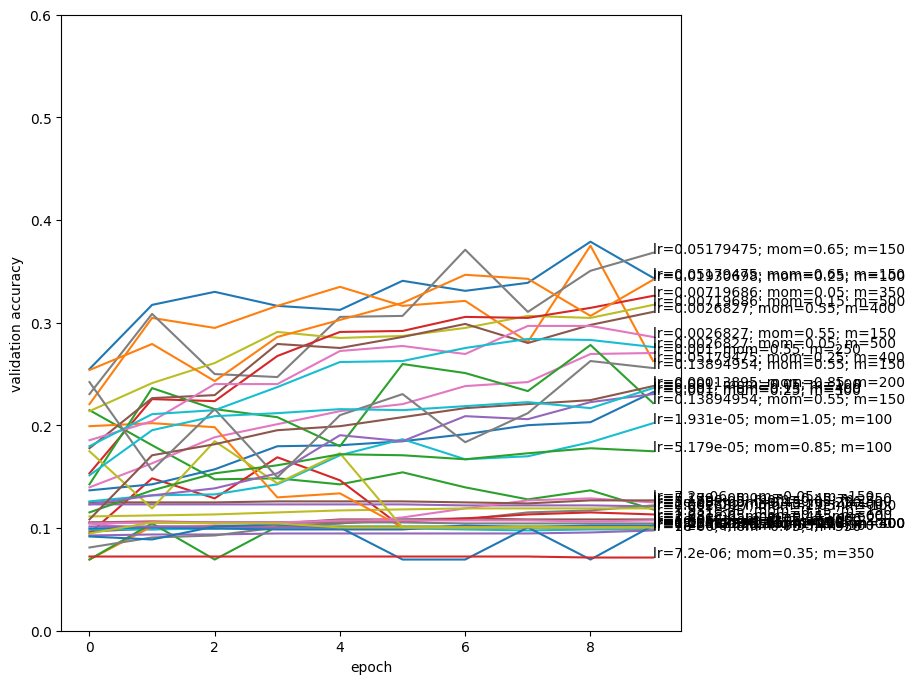

In [ ]:
epochs = range(0, len(parameters['val_acc'][0]))
num_searches = len(parameters['learning_rate'])


fig, ax = plt.subplots(figsize=(8,8))

for i in range(num_searches):  # or in best_3_search_indices:
    ax.plot(epochs, parameters['val_acc'][i], label='validation')
    ax.set_ylabel('validation accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylim([0, 0.6])
    line_label = (f"lr={np.round(parameters['learning_rate'][i], 8)}; "
                  f"mom={np.round(parameters['momentum_factor'][i], 5)}; "
                  f"m={parameters['hidden_layer_size'][i]}")
    ax.annotate(line_label, (epochs[-1], parameters['val_acc'][i][-1]))


#### Retrain the best-performing models on the full training dataset



In [ ]:
dim_in = 3072
dim_out = 10

best_results = {
      'learning_rate': [],
      'momentum_factor': [],
      'hidden_layer_size': [],
      'train_loss': [],
      'train_acc': [],
      'val_loss': [],
      'val_acc': [],
  }

for i in best_3_search_indices:
  lr = parameters['learning_rate'][i]
  momentum = parameters['momentum_factor'][i]
  m = parameters['hidden_layer_size'][i]

  print(f"lr={np.round(lr, 5)}; "
        f"mom={np.round(momentum, 5)}; "
        f"m={m}; "
        f"batch_size={batch_size}" )

  n_epochs = 50 

  model = fully_connected_neural_network(dim_in, m, dim_out)
  optim = SGD(model.parameters(), lr=lr, momentum=momentum)

  train_loss, train_acc, val_loss, val_acc = train(
      model,
      optim,
      train_full_loader,
      val_full_loader,
      epochs=n_epochs
  )

  print(f'train_loss: {train_loss}')
  print(f'train_acc: {train_acc}')
  print(f'val_loss: {val_loss}')
  print(f'val_acc: {val_acc}')

  best_results['learning_rate'].append(lr)
  best_results['momentum_factor'].append(momentum)
  best_results['hidden_layer_size'].append(m)
  best_results['train_loss'].append(train_loss)
  best_results['train_acc'].append(train_acc)
  best_results['val_loss'].append(val_loss)
  best_results['val_acc'].append(val_acc)

for key, item in parameters.items():
    parameters[key] = np.array(item)

lr=0.01931; mom=0.25; m=100; batch_size=256


  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: [2.0912690203298223, 1.9084881483153864, 1.8424329249696298, 1.7980946722355755, 1.7657044313170693, 1.7353681468150832, 1.707730309529738, 1.685587570748546, 1.6606406278230927, 1.6414701809937304, 1.6232631836425175, 1.6055218651890755, 1.5893046449531207, 1.5775947354056619, 1.5626996938477864, 1.5493082072247157, 1.536838066171516, 1.5255017124793746, 1.515373665500771, 1.5094311156056144, 1.4991452185945078, 1.4888546453280882, 1.4833480573513291, 1.4732462201606145, 1.4656045172702183, 1.462554600428451, 1.4497222290797667, 1.4457811482928016, 1.4395647184415297, 1.4291041127660058, 1.4226283607157795, 1.4190854186361486, 1.4119454717094249, 1.4046311188827862, 1.402748909186233, 1.3918862254782156, 1.3849843428893522, 1.3830162666060708, 1.3792127221822739, 1.3754548775878819, 1.3657510490580038, 1.3619214032183995, 1.3550878471948884, 1.3558022772723979, 1.346009906042706, 1.3437262218106876, 1.3434905328533866, 1.3387884639880874, 1.3304450112310322, 1.329063862562

  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: [1.9917730269106952, 1.8135991008444265, 1.7385245636105537, 1.6812677837230943, 1.6442559449510141, 1.6067147051746196, 1.5801407972520047, 1.5584933723915706, 1.5296255018223415, 1.5120243762027135, 1.491421634500677, 1.473419645970518, 1.458299588750709, 1.443784937262535, 1.4332419539039785, 1.410427768122066, 1.4020453535697677, 1.3849933817982674, 1.3707395195960999, 1.3589744479818777, 1.3500627387653699, 1.3418316421183674, 1.3266973624175245, 1.3151349411769346, 1.3048955953933976, 1.298922904513099, 1.282013711604205, 1.2772402323105119, 1.271800341253931, 1.2524497678334063, 1.2569560889493336, 1.243028312921524, 1.2239176664840092, 1.2246937934647908, 1.2111452560533176, 1.2074097415263003, 1.2020973603833804, 1.1949928843162276, 1.1772035441615365, 1.1699362708763643, 1.166100528429855, 1.158337795937603, 1.1548296087844805, 1.1441702365197919, 1.140017704191533, 1.1361832144585522, 1.1155303506688639, 1.110884854062037, 1.1140279532833532, 1.1014163368804888]


  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: [1.929926985366778, 1.7530836510387333, 1.6736979518424382, 1.6169979260726408, 1.5814915218136527, 1.54085726629604, 1.5182604837146672, 1.4983536336909642, 1.472426399588585, 1.460304548794573, 1.4447203515605493, 1.4225411774082617, 1.416566215455532, 1.3971812345764854, 1.3841856860301711, 1.3668620518662713, 1.3551348292014815, 1.3486307459798725, 1.3320449529723688, 1.3157854439182715, 1.3102712448347698, 1.2984176535498013, 1.2922072634100914, 1.2721545967188748, 1.2622473368590528, 1.258046379820867, 1.2608294554732062, 1.2401443774049932, 1.2327924235300585, 1.223955132744529, 1.2232166731899434, 1.2054746841842479, 1.2063906402750448, 1.197472829033028, 1.1877551593563773, 1.1749352155761286, 1.1692332662642002, 1.1663350063291462, 1.1578914973546157, 1.1505344571037726, 1.1373326104472985, 1.1387247473678805, 1.1314578852192922, 1.1247147565538234, 1.1175339577550238, 1.1147408905354412, 1.1054132712835616, 1.0995641940019347, 1.0947074561633847, 1.08993874287063

Plot the retrained, best-performing models.

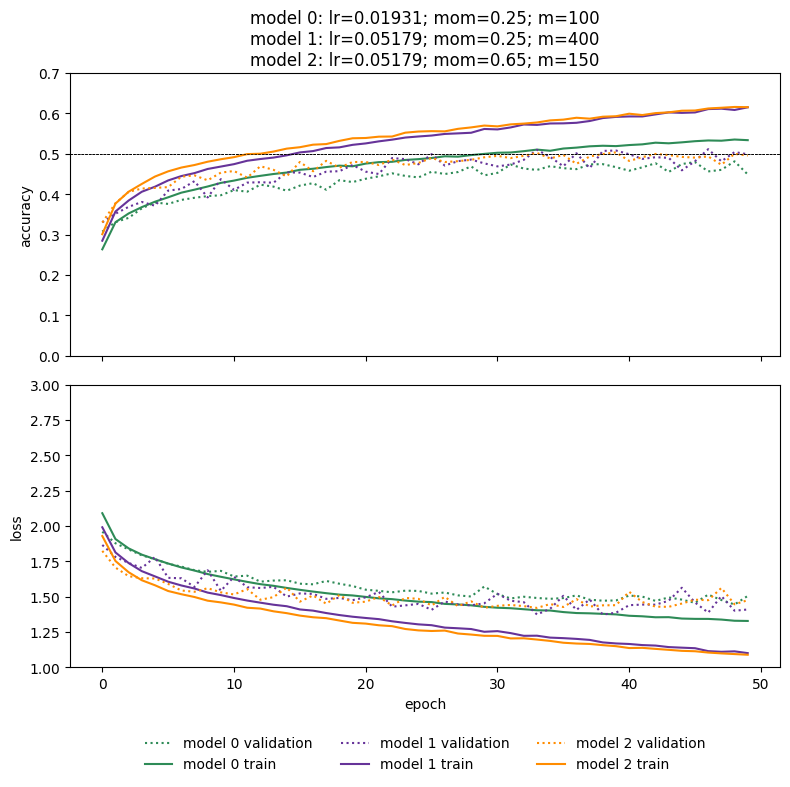

In [ ]:
epochs = range(0, n_epochs)

fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.1)

title_str = []
model_colors = ['seagreen', 'rebeccapurple', 'darkorange']

for i in range(len(best_results['learning_rate'])):

  ax[0].plot(epochs, best_results['val_acc'][i], label=f'model {i} validation', linestyle=':', color=model_colors[i])
  ax[0].plot(epochs, best_results['train_acc'][i], label=f'model {i} train', linestyle='-', color=model_colors[i])
  ax[0].set_ylabel('accuracy')
  ax[0].set_ylim([0, 0.7])
  ax[0].axhline(0.5, color='k', linestyle='--', linewidth=0.5)


  ax[1].plot(epochs, best_results['val_loss'][i], label=f'model {i} validation', linestyle=':', color=model_colors[i])
  ax[1].plot(epochs, best_results['train_loss'][i], label=f'model {i} train', linestyle='-', color=model_colors[i])
  ax[1].set_ylabel('loss')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylim([1, 3])
  ax[1].legend(frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(0.5, -.2))

  title_str.append(f"model {i}: "
                   f"lr={np.round(best_results['learning_rate'][i], 5)}; "
                   f"mom={np.round(best_results['momentum_factor'][i], 5)}; "
                   f"m={best_results['hidden_layer_size'][i]}")


ax[0].set_title('\n'.join(title_str))
fig.tight_layout()
# fig.savefig('best_3_fully_connected_neural_networks.png',  dpi=400)

### Convolutional layer with max-pool and fully-connected output:

$x^{out} = W_2 (\mathrm{MaxPool} (\mathrm{relu} ( \mathrm{Conv2d} (x^{in}, W_1) + b_1 ))) + b_2$

Where,

$\mathrm{Conv2d} (x^{in}, W_1) \in \R^{(33-k) \times (33-k) \times M}$

$\mathrm{MaxPool} (\mathrm{relu} ( \mathrm{Conv2d} (x^{in}, W_1) + b_1 )) \in \R^{(\frac{33-k}{N}) \times (\frac{33-k}{N}) \times M}$

$W_2 \in \R^{10 \times M(\frac{33-k}{N})^2};\; b_2 \in \R^{10}$

such that $M$, $k$, $N$ are model-specific hyperparameters.

In [17]:
def convolutional_neural_network(dim_in, m, k, n, dim_out) -> nn.Module:
    """Convolutional layer with max-pool and fully-connected output"""
    fc_input_size = int(m * ((33 - k)/n)**2)
    
    model =  nn.Sequential(
            nn.Conv2d(dim_in, m, k),  # (in, # filters, kernel size)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(n, n)),
            nn.Flatten(),
            nn.Linear(fc_input_size, dim_out),
         )
    return model.to(DEVICE)

Determine pooled output size of the MaxPool layer (p) using the MaxPool size (N) and Conv2D size (k).

In [8]:
k_n_combs = [(5, 14), (5, 7), (6, 9), (8, 5)]

for k, n in k_n_combs:
    print(f"{k},{n}")
    p = np.divide(33-k, n)
    print(f"p={p}")

5,2
n=14.0
5,4
n=7.0
6,3
n=9.0
8,5
n=5.0
5,14
p=2.0
5,7
p=4.0
6,9
p=3.0
8,5
p=5.0


#### Parameter search over the convolutional layer with max-pool and fully-connected output:

In [19]:
def parameter_search_convolutional_nn(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model_fn:Callable[[], nn.Module]
) -> float:
    """
    Parameter search over the neural network with a convolutional layer with 
    max-pool and fully-connected output.

    Args:
    train_loader: the train dataloader.
    val_loader: the validation dataloader.
    model_fn: a function that, when called, returns a torch.nn.Module.

    Returns:
    The train/vald losses and accuracies, learning rates, momentum factors,
    Conv2D size, number of Conv2D filters, and MaxPool size for each search
    iteration and train epoch.
    """
    dim_in = 3
    dim_out = 10
    learning_rates = torch.logspace(-4, 0, 15)
    momentum_factors = torch.linspace(0.05, 1.5, 20)

    conv2d_filters = torch.tensor([10, 20, 50, 100, 120, 150, 200])  # m_typ = 100;
    k_n_combs = [(5, 14), (5, 7), (6, 9), (8, 5)]  # k_typ = 5, n_typ = 14; pool_size = np.divide(33-k, n)
    n_epochs = 8
    num_searches = 50

    results = {
        'learning_rate': [],
        'momentum_factor': [],
        'conv2d_size': [],  # k
        'conv2d_filters': [],  # M
        'maxpool_size': [],  # N
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    for i in range(num_searches):
        learning_rate_sampler = torch.randint(low=0, high=len(learning_rates), size=(1,))
        momentum_factor_sampler = torch.randint(low=0, high=len(momentum_factors), size=(1,))
        conv2d_filters_sampler = torch.randint(low=0, high=len(conv2d_filters), size=(1,))
        k_n_combs_sampler = torch.randint(low=0, high=len(k_n_combs), size=(1,))

        lr = learning_rates[learning_rate_sampler].item()
        momentum = momentum_factors[momentum_factor_sampler].item()
        m = int(conv2d_filters[conv2d_filters_sampler].item())
        k, n = k_n_combs[k_n_combs_sampler]

        print(f"lr: {lr}; "
              f"momentum: {momentum}; "
              f"m: {m}; "
              f"k: {k}; "
              f"n: {n}; ")

        model = model_fn(dim_in, m, k, n, dim_out)

        optim = SGD(model.parameters(), lr=lr, momentum=momentum)

        train_loss, train_acc, val_loss, val_acc = train(
            model,
            optim,
            train_loader,
            val_loader,
            epochs=n_epochs
        )

        results['learning_rate'].append(lr)
        results['momentum_factor'].append(momentum)
        results['conv2d_size'].append(k)
        results['conv2d_filters'].append(m)
        results['maxpool_size'].append(n)
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

    return results

In [20]:
parameters = parameter_search_convolutional_nn(train_subset_loader,
                                               val_subset_loader,
                                               convolutional_neural_network)

for key, item in parameters.items():
    parameters[key] = np.array(item)

lr: 0.0026826958637684584; momentum: 0.05000000074505806; m: 50; k: 6; n: 9; 
450


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.00019306977628730237; momentum: 0.05000000074505806; m: 100; k: 6; n: 9; 
900


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.07196857035160065; momentum: 1.1947368383407593; m: 120; k: 5; n: 7; 
1920


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0013894954463467002; momentum: 1.271052598953247; m: 120; k: 8; n: 5; 
3000


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.03727593645453453; momentum: 0.7368420958518982; m: 120; k: 5; n: 7; 
1920


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0026826958637684584; momentum: 0.2789473831653595; m: 50; k: 5; n: 7; 
800


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0007196856895461679; momentum: 1.3473684787750244; m: 50; k: 5; n: 7; 
800


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 1.0; momentum: 1.4236842393875122; m: 50; k: 5; n: 14; 
200


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.5179474949836731; momentum: 1.271052598953247; m: 10; k: 5; n: 14; 
40


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.005179474595934153; momentum: 1.1184210777282715; m: 20; k: 6; n: 9; 
180


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.000372759357560426; momentum: 0.05000000074505806; m: 10; k: 5; n: 7; 
160


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 1.0; momentum: 0.12631578743457794; m: 150; k: 6; n: 9; 
1350


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 1.0; momentum: 0.2789473831653595; m: 120; k: 8; n: 5; 
3000


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.00019306977628730237; momentum: 0.3552631735801697; m: 20; k: 5; n: 14; 
80


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.13894954323768616; momentum: 0.7368420958518982; m: 150; k: 8; n: 5; 
3750


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0007196856895461679; momentum: 0.6605263352394104; m: 150; k: 6; n: 9; 
1350


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 1.0; momentum: 1.4236842393875122; m: 100; k: 5; n: 7; 
1600


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.00019306977628730237; momentum: 0.2789473831653595; m: 150; k: 5; n: 14; 
600


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.03727593645453453; momentum: 1.1184210777282715; m: 100; k: 5; n: 7; 
1600


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0013894954463467002; momentum: 0.3552631735801697; m: 150; k: 6; n: 9; 
1350


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.00019306977628730237; momentum: 0.05000000074505806; m: 100; k: 5; n: 14; 
400


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0013894954463467002; momentum: 0.05000000074505806; m: 50; k: 6; n: 9; 
450


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0007196856895461679; momentum: 1.1947368383407593; m: 50; k: 5; n: 14; 
200


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.019306978210806847; momentum: 1.1947368383407593; m: 100; k: 8; n: 5; 
2500


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.019306978210806847; momentum: 0.5842105150222778; m: 20; k: 6; n: 9; 
180


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.07196857035160065; momentum: 0.9657894372940063; m: 200; k: 5; n: 7; 
3200


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.005179474595934153; momentum: 1.271052598953247; m: 150; k: 8; n: 5; 
3750


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.03727593645453453; momentum: 0.20263157784938812; m: 200; k: 8; n: 5; 
5000


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.07196857035160065; momentum: 0.2789473831653595; m: 120; k: 5; n: 14; 
480


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.5179474949836731; momentum: 0.2789473831653595; m: 120; k: 6; n: 9; 
1080


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0026826958637684584; momentum: 1.1184210777282715; m: 10; k: 6; n: 9; 
90


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0026826958637684584; momentum: 1.5; m: 10; k: 8; n: 5; 
250


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.009999999776482582; momentum: 1.1184210777282715; m: 200; k: 5; n: 7; 
3200


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.00019306977628730237; momentum: 0.20263157784938812; m: 20; k: 8; n: 5; 
500


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.000372759357560426; momentum: 0.9657894372940063; m: 10; k: 5; n: 7; 
160


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.000372759357560426; momentum: 0.8131579160690308; m: 120; k: 6; n: 9; 
1080


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.00019306977628730237; momentum: 0.12631578743457794; m: 150; k: 8; n: 5; 
3750


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.005179474595934153; momentum: 0.50789475440979; m: 10; k: 5; n: 14; 
40


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.019306978210806847; momentum: 0.8894736766815186; m: 20; k: 5; n: 14; 
80


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 1.0; momentum: 0.8894736766815186; m: 50; k: 5; n: 14; 
200


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.000372759357560426; momentum: 0.5842105150222778; m: 20; k: 6; n: 9; 
180


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.07196857035160065; momentum: 1.0421051979064941; m: 200; k: 8; n: 5; 
5000


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.005179474595934153; momentum: 1.0421051979064941; m: 100; k: 5; n: 7; 
1600


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 1.0; momentum: 0.43157896399497986; m: 200; k: 6; n: 9; 
1800


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.019306978210806847; momentum: 1.5; m: 200; k: 8; n: 5; 
5000


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 9.999999747378752e-05; momentum: 1.1947368383407593; m: 100; k: 6; n: 9; 
900


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.07196857035160065; momentum: 0.6605263352394104; m: 200; k: 6; n: 9; 
1800


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.0026826958637684584; momentum: 0.12631578743457794; m: 50; k: 6; n: 9; 
450


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 0.5179474949836731; momentum: 0.50789475440979; m: 20; k: 5; n: 14; 
80


  0%|          | 0/8 [00:00<?, ?it/s]

lr: 9.999999747378752e-05; momentum: 1.271052598953247; m: 200; k: 5; n: 7; 
3200


  0%|          | 0/8 [00:00<?, ?it/s]

Extract the best-performing model indices.

In [23]:
best_search_index = np.argmax(np.max(parameters['val_acc'], axis=1))
best_3_search_indices = np.argpartition(np.max(parameters['val_acc'][:,-5:], axis=1), -3)[-3:]
best_3_search_indices = best_3_search_indices[np.argsort(np.max(parameters['val_acc'], axis=1)[best_3_search_indices])]
best_3_search_indices

array([25, 46,  4])

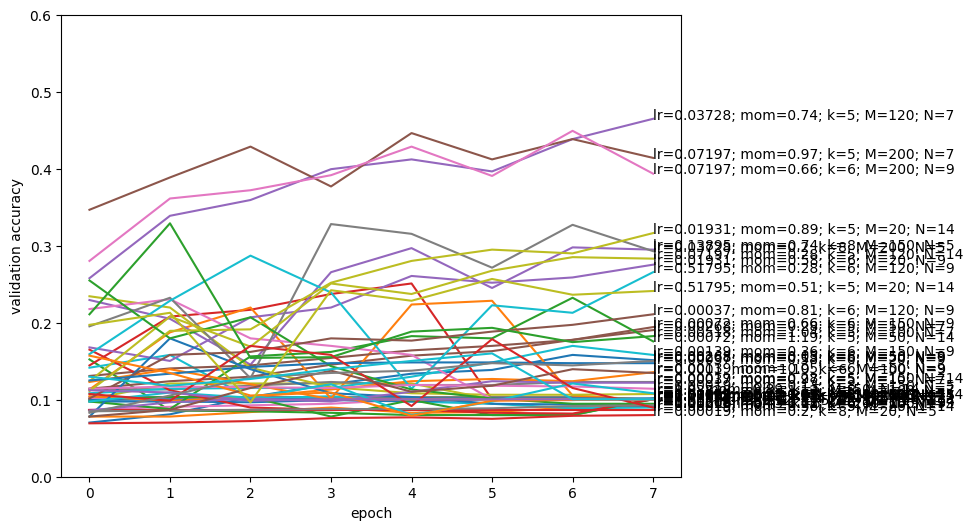

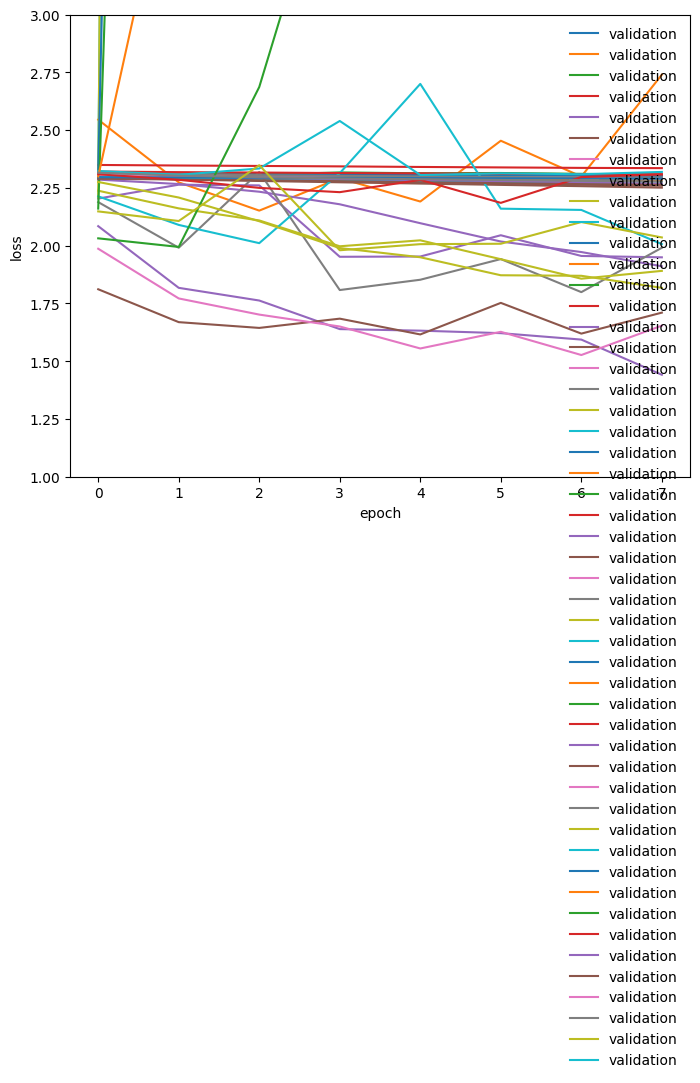

In [24]:
epochs = range(0, len(parameters['val_acc'][0]))
num_searches = len(parameters['learning_rate'])

fig, ax = plt.subplots(figsize=(8,6))
for i in range(num_searches):  # or in best_3_search_indices:
    ax.plot(epochs, parameters['val_acc'][i], label='validation')
    ax.set_ylabel('validation accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylim([0, 0.6])
    line_label = (f"lr={np.round(parameters['learning_rate'][i], 5)}; "
                  f"mom={np.round(parameters['momentum_factor'][i], 2)}; "
                  f"k={np.round(parameters['conv2d_size'][i], 5)}; "
                  f"M={np.round(parameters['conv2d_filters'][i], 5)}; "
                  f"N={parameters['maxpool_size'][i]}")

    ax.annotate(line_label, (epochs[-1], parameters['val_acc'][i][-1]))

fig, ax = plt.subplots(figsize=(8,6))
for i in range(num_searches):
    ax.plot(epochs, parameters['val_loss'][i], label='validation')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.set_ylim([1, 3])
    line_label = (f"lr={np.round(parameters['learning_rate'][i], 5)}; "
                  f"mom={np.round(parameters['momentum_factor'][i], 2)}; "
                  f"k={np.round(parameters['conv2d_size'][i], 5)}; "
                  f"M={np.round(parameters['conv2d_filters'][i], 5)}; "
                  f"N={parameters['maxpool_size'][i]}")

    ax.annotate(line_label, (epochs[-1], parameters['val_acc'][i][-1]))

Retrain the best three models

In [25]:
dim_in = 3
dim_out = 10

best_results = {
    'learning_rate': [],
    'momentum_factor': [],
    'conv2d_size': [],  # k
    'conv2d_filters': [],  # M
    'maxpool_size': [],  # N
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
  }

for i in best_3_search_indices:
  lr = parameters['learning_rate'][i]
  momentum = parameters['momentum_factor'][i]
  k = parameters['conv2d_size'][i]
  m = parameters['conv2d_filters'][i]
  n = parameters['maxpool_size'][i]

  print(f"lr={np.round(lr, 5)}; "
        f"mom={np.round(momentum, 5)}; "
        f"k={k}; "
        f"m={m}; "
        f"n={n}; "
        f"batch_size={batch_size_full}" )

  n_epochs = 65

  model = convolutional_neural_network(dim_in, m, k, n, dim_out)
  optim = SGD(model.parameters(), lr=lr, momentum=momentum)

  train_loss, train_acc, val_loss, val_acc = train(
      model,
      optim,
      train_full_loader,
      val_full_loader,
      epochs=n_epochs
  )

  print(f'train_loss: {train_loss}')
  print(f'train_acc: {train_acc}')
  print(f'val_loss: {val_loss}')
  print(f'val_acc: {val_acc}')


  best_results['learning_rate'].append(lr)
  best_results['momentum_factor'].append(momentum)
  best_results['conv2d_size'].append(k)
  best_results['conv2d_filters'].append(m)
  best_results['maxpool_size'].append(n)
  best_results['train_loss'].append(train_loss)
  best_results['train_acc'].append(train_acc)
  best_results['val_loss'].append(val_loss)
  best_results['val_acc'].append(val_acc)

for key, item in parameters.items():
    parameters[key] = np.array(item)

lr=0.07197; mom=0.96579; k=5; m=200; n=7; batch_size=512
3200


  0%|          | 0/65 [00:00<?, ?it/s]

train_loss: [1.7438453991304745, 1.342682579701597, 1.2619563286954707, 1.216818634759296, 1.1729673946445638, 1.201528948816386, 1.1454191709106618, 1.1421117667447438, 1.1500395983457565, 1.1508559388193218, 1.1344620409336956, 1.1319331540302797, 1.139728458090262, 1.1809432845224033, 1.0974959507584572, 1.1169209785082124, 1.07661180740053, 1.0548000518571248, 1.086594850502231, 1.060988812284036, 1.04385165666992, 1.071166712452065, 1.047172791578553, 1.0185021372003988, 1.0023717324842105, 0.987794968214902, 0.9883146502754905, 1.0157633315433154, 1.0058952698653394, 1.0097157257524403, 1.0531910969452425, 1.0157639479095286, 1.0077305646105246, 0.9859306866472418, 0.9821060001850128, 0.9711087603460659, 0.9394868639382449, 0.93413495272398, 1.0009793618863279, 0.9870386977087368, 0.9672808132388375, 0.9583012001080946, 0.9939494044943289, 0.9558759880336848, 0.9485629329627211, 0.9153008880940351, 0.9397261528806253, 0.9736038676717065, 0.9806594015522436, 0.9653460369868712, 0.

  0%|          | 0/65 [00:00<?, ?it/s]

train_loss: [1.8968656401742587, 1.5673135275190526, 1.4444069225679745, 1.3800564597953449, 1.3214429034428163, 1.271825603463433, 1.2333429916338488, 1.1977744983001188, 1.1645163920792667, 1.1480400819670071, 1.1236229891126805, 1.1108497828245163, 1.0928795710206032, 1.085100407627496, 1.0618400235067715, 1.0458942665295168, 1.0415827171369032, 1.0240700630979105, 1.0157956704497337, 1.0102988359603016, 0.997825754637068, 0.9885288592089306, 0.9765106405724179, 0.9729174138470129, 0.9588721204887737, 0.9438106945969842, 0.9375636774030599, 0.9314014918424867, 0.9314219125292518, 0.9230060773816976, 0.920071161606095, 0.9030677432363684, 0.9107131775129925, 0.896079805764285, 0.8902066018093716, 0.8773262703960593, 0.8821424042636697, 0.8602359552275051, 0.8720819943330504, 0.8603472282940691, 0.8534122989936308, 0.845813357017257, 0.8415482538667592, 0.8498699969866059, 0.8268694098700177, 0.8323436013676904, 0.8216896646402099, 0.8145188269290057, 0.8130611113526605, 0.80689851804

  0%|          | 0/65 [00:00<?, ?it/s]

train_loss: [1.9744848920540377, 1.6293294876813889, 1.5015673732215709, 1.4282589243216948, 1.3757189403880725, 1.3312339200214907, 1.2929730808193034, 1.2500891279090534, 1.217987754128196, 1.1909722523255781, 1.1566407829523087, 1.1435834223573857, 1.1165261322801763, 1.1165130070664666, 1.0922101519324563, 1.0774414586749943, 1.0677673559297214, 1.0477809899232604, 1.0368794426321983, 1.0306147093122655, 1.0212930264798077, 1.007480926811695, 1.003761756826531, 0.9955357245423577, 0.9856161712245508, 0.9763581163503907, 0.9689086939800869, 0.961373703723604, 0.9632594598965212, 0.9530806277285923, 0.9453739334236492, 0.9382708411325108, 0.931774415075779, 0.9277815358205275, 0.9215047772635113, 0.918739954856309, 0.9096645347096703, 0.907375806434588, 0.8977942927317186, 0.891847197982398, 0.8923738571730527, 0.8854218287901445, 0.8857291022484953, 0.8781722594391216, 0.8768119351430372, 0.8723134784535929, 0.8654500056396831, 0.8572055358778347, 0.8602026003328237, 0.8523468564857

Plot the retrained best-performing models.

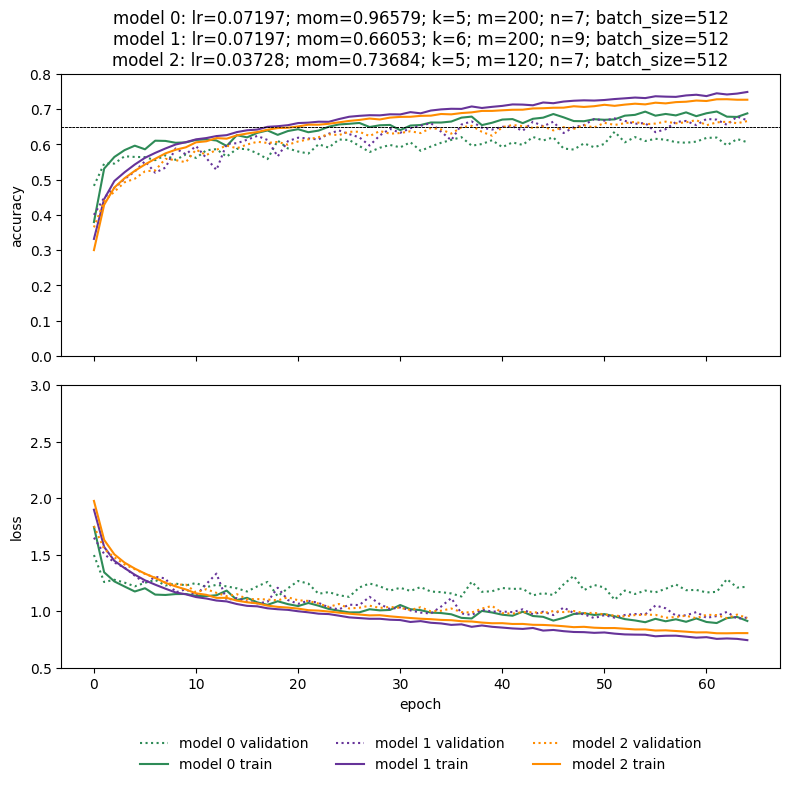

In [30]:
epochs = range(0, n_epochs)

fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.1)

title_str = []
model_colors = ['seagreen', 'rebeccapurple', 'darkorange']

for i in range(len(best_results['learning_rate'])):

  ax[0].plot(epochs, best_results['val_acc'][i], label=f'model {i} validation', linestyle=':', color=model_colors[i])
  ax[0].plot(epochs, best_results['train_acc'][i], label=f'model {i} train', linestyle='-', color=model_colors[i])
  ax[0].set_ylabel('accuracy')
  ax[0].set_ylim([0, 0.8])
  ax[0].axhline(0.65, color='k', linestyle='--', linewidth=0.5)


  ax[1].plot(epochs, best_results['val_loss'][i], label=f'model {i} validation', linestyle=':', color=model_colors[i])
  ax[1].plot(epochs, best_results['train_loss'][i], label=f'model {i} train', linestyle='-', color=model_colors[i])
  ax[1].set_ylabel('loss')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylim([0.5, 3])
  ax[1].legend(frameon=False, ncols=3, loc='upper center', bbox_to_anchor=(0.5, -.2))

  title_str.append(f"model {i}: "
                   f"lr={np.round(best_results['learning_rate'][i], 5)}; "
                   f"mom={np.round(best_results['momentum_factor'][i], 5)}; "
                   f"k={np.round(best_results['conv2d_size'][i], 5)}; "
                   f"m={np.round(best_results['conv2d_filters'][i], 5)}; "
                   f"n={np.round(best_results['maxpool_size'][i], 5)}; "
                   f"batch_size={batch_size_full}")

ax[0].set_title('\n'.join(title_str))
fig.tight_layout()
fig.savefig('best_3_convolutional_neural_networks.png',  dpi=400)
          


#### Evaluate

In [ ]:
def evaluate(
    model: nn.Module, loader: DataLoader
) -> Tuple[float, float]:
    """Computes test loss and accuracy of model on loader."""
    loss = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for (batch, labels) in loader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            y_batch_pred = model(batch)
            batch_loss = loss(y_batch_pred, labels)
            test_loss = test_loss + batch_loss.item()

            pred_max = torch.argmax(y_batch_pred, 1)
            batch_acc = torch.sum(pred_max == labels)
            test_acc = test_acc + batch_acc.item()
        test_loss = test_loss / len(loader)
        test_acc = test_acc / (batch_size * len(loader))
        return test_loss, test_acc

In [ ]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc}")